# Estimer la tendance centrale sur le cas de la poutre en flexion


In [1]:
import openturns as ot
import openturns.viewer as otv
import math
import tabulate

**Remarque.** Le script suivant utilise la classe `MemoizeFunction` pour exploiter le mécanisme d'historique.  Il faut toutefois faire attention à la consommation mémoire si le cache n'est pas nécessaire, surtout avant de lancer des simulations Monte-Carlo. En effet, cela peut générer une empreinte mémoire importante à cause du stockage des points.

In [2]:
ot.RandomGenerator.SetSeed(0)

distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # in m
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # in m^4
distributionI.setDescription(["I"])

distributionCollection = [distributionE, distributionF, distributionL, distributionI]
X = ot.JointDistribution(distributionCollection)
X

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 3.5, a = 6.5e+10, b = 7.5e+10)"
1,F,"ParametrizedDistribution(parameters = LogNormalMuSigma(mu = 300, sigma = 30, gamma = 0))"
2,L,"Uniform(a = 2.5, b = 2.6)"
3,I,"Beta(alpha = 2.5, beta = 4, a = 1.3e-07, b = 1.7e-07)"


In [3]:

g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (m)"])

g = ot.MemoizeFunction(g)

XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (m)"])

## Par développement de Taylor

In [ ]:
taylor_without_dependence = ot.TaylorExpansionMoments(Y)
taylor_without_dependence.getMeanFirstOrder()[0]

0.1701111380145278

In [5]:
taylor_without_dependence.getMeanSecondOrder()[0]

0.1706969419399231

In [6]:
taylor_without_dependence.getCovariance()[0, 0]

0.0004112803852960523

In [7]:
math.sqrt(taylor_without_dependence.getCovariance()[0, 0])

0.020280048947082262

In [8]:
importanceFactors = taylor_without_dependence.getImportanceFactors()
importanceFactors

class=PointWithDescription name=Unnamed dimension=4 description=[E,F,L,I] values=[0.0471628,0.703601,0.0811537,0.168082]

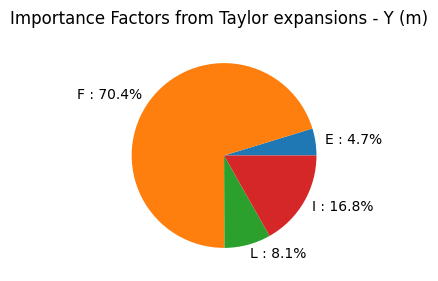

In [9]:
graph = taylor_without_dependence.drawImportanceFactors()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Par Monte-Carlo simple avec un budget fixé

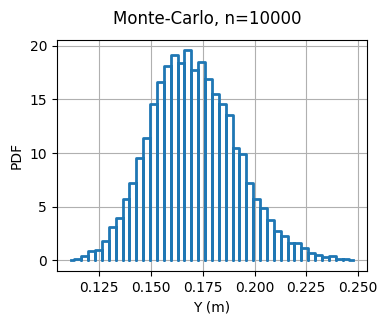

In [10]:
n = 10000

Ysample = Y.getSample(n)

graph = ot.HistogramFactory().build(Ysample).drawPDF()
graph.setTitle("Monte-Carlo, n=%d" % (n))
graph.setXTitle("Y (m)")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [11]:
Ysample.computeMean()[0]

0.17052409816264258

In [12]:
Ysample.computeVariance()[0]

0.0004227222866206568

In [13]:
Ysample.computeStandardDeviation()[0]

0.020560211249417083

## Par Monte-Carlo simple avec un algorithme itératif


In [14]:
g.clearHistory()

In [15]:
algo = ot.ExpectationSimulationAlgorithm(Y)
algo.setMaximumOuterSampling(1000)
algo.setBlockSize(32)  # Proportionnel au nombre de processeurs
algo.setMaximumCoefficientOfVariation(0.01)
algo.run()
result = algo.getResult()

In [16]:
outerSampleSize = result.getOuterSampling()
print(f"Nombre d'itérations = {outerSampleSize}")

expectation = result.getExpectationEstimate()
print(f"Moyenne = {expectation[0]:f}")

blocksize = result.getBlockSize()
sampleSize = outerSampleSize * blocksize
print(f"Nombre d'appels à g = {sampleSize}")

cv = result.getCoefficientOfVariation()[0]
print(f"Coef. de variation = {cv:.6f}")

Nombre d'itérations = 6
Moyenne = 0.168222
Nombre d'appels à g = 192
Coef. de variation = 0.009190


Normal(mu = 0.168222, sigma = 0.00154594)


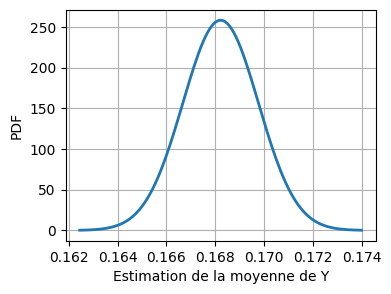

In [17]:
expectationDistribution = result.getExpectationDistribution()
expectationDistribution.setDescription(["Estimation de la moyenne de Y"])
print(expectationDistribution)
graph = expectationDistribution.drawPDF()
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [18]:
confidenceLevel = 0.95
sample_mean_CI = expectationDistribution.computeBilateralConfidenceInterval(
    confidenceLevel
)
lower_bound = sample_mean_CI.getLowerBound()[0]
upper_bound = sample_mean_CI.getUpperBound()[0]
print(f"La probabilité que l'intervalle [{lower_bound:.4f}, {upper_bound:.4f}] ")
print(f"contienne la vraie moyenne est égale à {100.0 * confidenceLevel:.2f} %.")

La probabilité que l'intervalle [0.1652, 0.1713] 
contienne la vraie moyenne est égale à 95.00 %.


In [19]:
Ysample = g.getOutputHistory()
sampleSize = Ysample.getSize()
print("Variance = %.4f" % (Ysample.computeVariance()[0]))

Variance = 0.0005


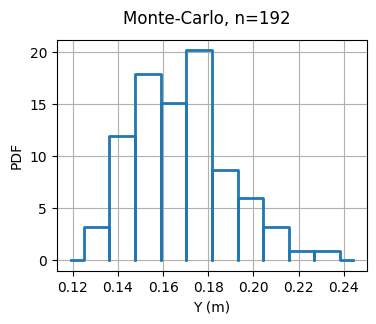

In [20]:
graph = ot.HistogramFactory().build(Ysample).drawPDF()
graph.setTitle("Monte-Carlo, n=%d" % (sampleSize))
graph.setXTitle("Y (m)")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Solution de l'exercice 1 : vérifications du développement de Taylor

In [21]:
muX = X.getMean()
muX

class=Point name=Unnamed dimension=4 values=[6.70455e+10,300,2.55,1.45385e-07]

In [22]:
muY = g(muX)
muY[0]

0.1701111380145278

In [23]:
taylor = ot.TaylorExpansionMoments(Y)
taylor.getMeanFirstOrder()[0]

0.1701111380145278

On observe que la valeur de retour de `taylor.getMeanFirstOrder()` coïncide exactement avec $g(\mu)$.

In [24]:
gradient = g.gradient(muX)
gradient

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-2.53725e-12,0.000567037,0.200131,-1.17008e+06]

In [25]:
covX = X.getCovariance()
covX

class=CovarianceMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[3.01309e+18,0,0,0,0,900,0,0,0,0,0.000833333,0,0,0,0,5.04931e-17]

In [26]:
dim = len(distributionCollection)
varianceY = 0.0
for i in range(dim):
    varianceY += gradient[i, 0] ** 2 * covX[i, i]
varianceY

0.0004112803852960523

In [27]:
taylor.getCovariance()[0, 0]

0.0004112803852960523

L'estimation de la variance par notre algorithme est identique à la valeur de retour de `getCovariance()`.

Pour compléter l'exercice, on utilise la méthode d'estimation de la moyenne par le développement de Taylor à l'ordre 2.

In [28]:
taylor.getMeanSecondOrder()[0]

0.1706969419399231

In [29]:
hessian = g.hessian(muX)
muY = g(muX)[0]
for i in range(dim):
    muY += 0.5 * hessian[i, i, 0] * covX[i, i]
muY

0.1706969419399231

On observe que notre algorithme produit le même résultat que la méthode `getMeanSecondOrder()`.

## Solution de l'exercice 2 : loi de la moyenne empirique


In [30]:
n = 100
Ysample = Y.getSample(n)
sigma = Ysample.computeStandardDeviation()[0]
sigma

0.02295282810488207

In [31]:
r = 1000
meanSample = ot.Sample(r, 1)
for k in range(r):
    Ysample = Y.getSample(n)
    meanSample[k, 0] = Ysample.computeMean()[0]

Le résultat attendu est que la distribution de la moyenne empirique est proche, lorsque $n$ est grand, de la loi gaussienne asymptotique $\mathcal{N}\left(\mu_Y, \frac{\sigma_Y^2}{n}\right)$ où $\mu_Y = \mathbb{E}[Y]$ est l'espérance de la sortie et $\sigma_Y^2 = \operatorname{Var}(Y)$ est la variance. Le problème est que ni $\mu_Y$ ni $\sigma_Y^2$ ne sont connus de manière exacte. Par conséquent, il est possible de représenter la distribution des observations de la moyenne empirique (par exemple, avec un histogramme), mais il n'est, en toute rigueur, pas possible de représenter la distribution exacte asymptotique gaussienne attendue. Pour tracer la loi $\mathcal{N}\left(\mu_Y, \frac{\sigma_Y^2}{n}\right)$, nous devons estimer $\mu_Y$ et $\sigma_Y^2$.

- Pour estimer $\sigma_Y$, nous utilisons l'écart-type empirique obtenu avec un seul échantillon de taille $n$, c'est-à-dire à partir de `Ysample` (l'échantillon de la variable de sortie) et non de `meanSample`.
- Pour estimer $\mu_Y$, nous pourrions utiliser la moyenne empirique avec un seul échantillon de taille $n$. Si nous le faisons, nous obtenons une distribution gaussienne centrée sur cette unique estimation. En conséquence, l'histogramme des moyennes empiriques obtenues avec $r$ répétitions se trouve décalé par rapport à la loi gaussienne centrée sur une seule estimation. Dans le but de pouvoir comparer les variances de l'histogramme et de la loi gaussienne de manière graphique (c'est-à-dire leur étalement horizontal), il est nécessaire que leurs centrages soient alignés. Pour cela, il est plus pertinent d'utiliser la moyenne empirique de l'échantillon `meanSample`. En effet, la taille de l'échantillon considéré alors est égale à $nr$, ce qui est plus grand et mène par conséquent à une estimation plus précise de $\mu_Y$.

In [32]:
mu = meanSample.computeMean()[0]
mu

0.17076995960495858

In [33]:
M = ot.Normal(mu, sigma / math.sqrt(n))
M

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0.17077] sigma=class=Point name=Unnamed dimension=1 values=[0.00229528] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

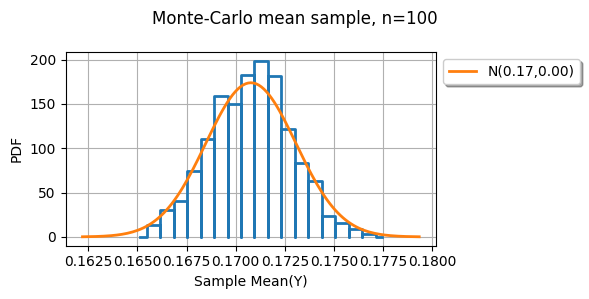

In [34]:
graph = ot.HistogramFactory().build(meanSample).drawPDF()
graph.setTitle("Monte-Carlo mean sample, n=%d" % (n))
graph.setXTitle("Sample Mean(Y)")
graph.setLegends([""])
gausspdf = M.drawPDF()
gausspdf.setLegends(["N(%.2f,%.2f)" % (mu, sigma / math.sqrt(n))])
graph.add(gausspdf)
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (6.0, 3.0)})

On observe que la distribution empirique de la moyenne empirique est proche de la distribution gaussienne.

Pour observer l'influence du paramètre $n$, on définit une fonction qui génère un échantillon de moyennes empiriques et retourne cet échantillon, ainsi que la loi gaussienne associée.

In [35]:
def resampleMean(n, r):
    meanSample = ot.Sample(r, 1)
    for k in range(r):
        Ysample = Y.getSample(n)
        meanSample[k, 0] = Ysample.computeMean()[0]
    return meanSample

In [36]:
meanSample100 = resampleMean(100, r)
meanSample400 = resampleMean(400, r)

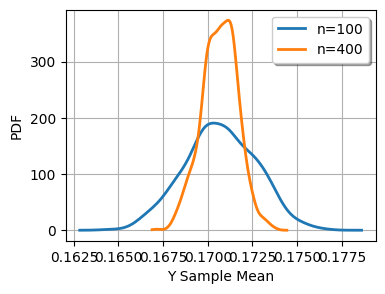

In [37]:
graph = ot.KernelSmoothing().build(meanSample100).drawPDF()
graph.setTitle("")
graph.setXTitle("Y Sample Mean")
graph.setLegends(["n=100"])
graph400 = ot.KernelSmoothing().build(meanSample400).drawPDF()
graph400.setLegends(["n=400"])
graph.add(graph400)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que la distribution de la moyenne empirique est plus resserrée avec $n=400$. C'est le résultat attendu, puisque la variance de l'estimateur de la moyenne empirique est divisée par 4 lorsqu'on augmente la taille de l'échantillon de $n=100$ à $n=400$.

In [38]:
def scaledMeanSample(n, r, mu, sigma):
    sample = ot.Sample(r, 1)
    for k in range(r):
        Ysample = Y.getSample(n)
        sample[k, 0] = math.sqrt(n) * (Ysample.computeMean()[0] - mu) / sigma
    return sample

## Solution de l'exercice 3 : fixer une variable

Pour fixer la variable $L$ à sa valeur moyenne, nous utilisons la méthode `getMean()`.

In [39]:
Lmean = distributionI.getMean()[0]
Lmean

1.4538461538461538e-07

La distribution de Dirac est une distribution qui permet de fixer une variable à une valeur constante, puisque sa densité de probabilité est infinie en un point, et nulle ailleurs.

In [40]:
L_fixed = ot.Dirac(Lmean)
distributionCollectionFixed = [distributionE, distributionF, L_fixed, distributionI]
Xfixed = ot.JointDistribution(distributionCollectionFixed)

XRVfixed = ot.RandomVector(Xfixed)
Yfixed = ot.CompositeRandomVector(g, XRVfixed)

taylorFixed = ot.TaylorExpansionMoments(Yfixed)

**Remarque.** Une alternative consiste à créer un nouveau couple formé du modèle probabiliste associé au vecteur $(E, F, I)$ et à une fonction paramétrique prenant en entrée $(E, F, I)$ et dans laquelle la valeur de $L$ est un paramètre. Dans ce contexte, nous utiliserions la classe `ParametricFunction`.

In [41]:
taylorFixed.getMeanFirstOrder()[0]

3.152590512486209e-23

In [42]:
taylorFixed.getCovariance()[0, 0]

1.2979276672060047e-47

Le tableau suivant compare le développement de Taylor lorsque L suit la loi uniforme et lorsque L est fixé à sa valeur moyenne. On observe que la moyenne est inchangée, ce qui est le résultat attendu puisque la moyenne estimée par le développement de Taylor ne dépend pas de la variance du vecteur d'entrée. On observe que la variance a été un peu réduite. 

| Méthode | Moyenne | Variance |
|--|--|--|
| Taylor, 1er ordre $(E,F,L,I)$ | 0.1701 | $0.4112 \times 10^{-3}$ |
| Taylor, 1er ordre $(E,F,\mu_L,I)$ | 0.1701 | $0.3779 \times 10^{-3}$ |

**Tableau 1.** Impact du remplacement de la variable $L$ par une constante sur le développement de Taylor.


Pour comprendre la réduction de variance issue du remplacement de $L$ par une constante, on analyse la perte de variance du développement de Taylor à l'ordre 1. On observe d'abord le modèle initial où on considère le vecteur aléatoire $(E, F, L, I)$. La variance de la sortie $Y$ est :

$$
\operatorname{Var}(Y) 
= \left(\frac{\partial g}{\partial E}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(E) 
+ \left(\frac{\partial g}{\partial F}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(F)
+ \left(\frac{\partial g}{\partial L}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(L)
+ \left(\frac{\partial g}{\partial I}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(I).
$$

Soit $\widetilde{Y}$ la variable aléatoire de sortie associée au vecteur aléatoire $(E, F, I)$ où $L = \mu_L$ est fixé.

La variance de la sortie $\widetilde{Y}$ est :

$$
\operatorname{Var}(\widetilde{Y}) 
= \left(\frac{\partial g}{\partial E}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(E) 
+ \left(\frac{\partial g}{\partial F}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(F)
+ \left(\frac{\partial g}{\partial I}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(I).
$$

Par conséquent :

$$
\operatorname{Var}(Y)
= \operatorname{Var}(\widetilde{Y}) + \left(\frac{\partial g}{\partial L}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(L).
$$

Par définition du facteur d'importance $\eta_L$ associé au vecteur aléatoire $(E, F, L, I)$, on a :

$$
\eta_L = \frac{\left(\frac{\partial g}{\partial L}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(L)}{\operatorname{Var}(Y)}.
$$

Cela implique :

$$
\operatorname{Var}(Y)
= \operatorname{Var}(\widetilde{Y}) + \eta_L \operatorname{Var}(Y).
$$

Par conséquent la perte de variance est :

$$
\operatorname{Var}(Y) - \operatorname{Var}(\widetilde{Y}) = \eta_L \operatorname{Var}(Y).
$$

La perte relative de variance est précisément égale au facteur d'importance :

$$
\eta_L
= \frac{\operatorname{Var}(Y) - \operatorname{Var}(\widetilde{Y})}{\operatorname{Var}(Y)}.
$$


Le calcul suivant évalue la perte de variance entre le modèle inconditionnel et le modèle conditionné. 

In [43]:
taylor.getCovariance()[0, 0] - taylorFixed.getCovariance()[0, 0]

0.0004112803852960523

Le calcul suivant évalue la perte de variance prédite par le facteur d'importance de la variable $L$. On observe que la perte de variance est très proche de celle prédite.

In [44]:
importanceFactors[2] * taylor.getCovariance()[0, 0]

3.337693111487634e-05

In [45]:
perte_variance_relative = (taylor.getCovariance()[0, 0] - taylorFixed.getCovariance()[0, 0]) / taylor.getCovariance()[0, 0]
print(f"perte_variance_relative = {perte_variance_relative}")
print(f"importanceFactors[2] = {importanceFactors[2]}")

perte_variance_relative = 1.0
importanceFactors[2] = 0.08115371485768909


## Solution de l'exercice 4 : développement de Taylor avec dépendance

In [46]:
dim = len(distributionCollection)
matrice_correlation_Spearman = ot.CorrelationMatrix(dim)
matrice_correlation_Spearman[2, 3] = -0.2
matrice_correlation_Spearman

class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,-0.2,0,0,-0.2,1]

In [47]:
matrice_correlation_Pearson = ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(matrice_correlation_Spearman)
matrice_correlation_Pearson

class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,-0.209057,0,0,-0.209057,1]

In [48]:
copula = ot.NormalCopula(matrice_correlation_Pearson)
copula

class=NormalCopula name=NormalCopula dimension=4 correlation=class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,-0.209057,0,0,-0.209057,1]

In [49]:
Xgauss = ot.JointDistribution(distributionCollection, copula)
XRVgauss = ot.RandomVector(Xgauss)
Ygauss = ot.CompositeRandomVector(g, XRVgauss)
Ygauss.setDescription(["Y, gaussien (m)"])

In [50]:
taylor_with_dependence = ot.TaylorExpansionMoments(Ygauss)
print(f"Taylor, Moyenne, 1er ordre : {taylor_with_dependence.getMeanFirstOrder()[0]:.4f}")
print(f"Taylor, Moyenne, 2nd ordre : {taylor_with_dependence.getMeanSecondOrder()[0]:.4f}")
print(f"Taylor, Variance : {taylor_with_dependence.getCovariance()[0, 0]:.4f}")
print(f"Taylor, Écart-type : {math.sqrt(taylor_with_dependence.getCovariance()[0, 0]):.4f}")

Taylor, Moyenne, 1er ordre : 0.1701
Taylor, Moyenne, 2nd ordre : 0.1708
Taylor, Variance : 0.0004
Taylor, Écart-type : 0.0208


In [51]:
taylor_with_dependence.getImportanceFactors()

class=PointWithDescription name=Unnamed dimension=4 description=[E,F,L,I] values=[0.0450406,0.671942,0.1,0.183017]

In [52]:
taylor_with_dependence.getGradientAtMean()

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-2.53725e-12,0.000567037,0.200131,-1.17008e+06]

La table suivante permet de comparer les résultats numériques sans et avec dépendance.


In [53]:
data = []
data.append(
    [
        "Moyenne Taylor, 1er ordre",
        taylor_without_dependence.getMeanFirstOrder()[0],
        taylor_with_dependence.getMeanFirstOrder()[0],
    ]
)
data.append(
    [
        "Moyenne Taylor, 2nd ordre",
        taylor_without_dependence.getMeanSecondOrder()[0],
        taylor_with_dependence.getMeanSecondOrder()[0],
    ]
)
data.append(
    [
        "Écart-type Taylor, 1er ordre",
        math.sqrt(taylor_without_dependence.getCovariance()[0, 0]),
        math.sqrt(taylor_with_dependence.getCovariance()[0, 0]),
    ]
)
importanceFactorsWithoutDependence = taylor_without_dependence.getImportanceFactors()
importanceFactorsWithDependence = taylor_with_dependence.getImportanceFactors()
data.append(
    [
        r"ηE",
        importanceFactorsWithoutDependence[0],
        importanceFactorsWithDependence[0],
    ]
)
data.append(
    [
        r"ηF",
        importanceFactorsWithoutDependence[1],
        importanceFactorsWithDependence[1],
    ]
)
data.append(
    [
        r"ηL",
        importanceFactorsWithoutDependence[2],
        importanceFactorsWithDependence[2],
    ]
)
data.append(
    [
        r"ηI",
        importanceFactorsWithoutDependence[3],
        importanceFactorsWithDependence[3],
    ]
)
print("Tableau 2. Comparaison des estimations par développement de Taylor sans et avec dépendance.")
tabulate.tabulate(
    data,
    headers=["Quantité d'intérêt", "Sans dépendance", "Avec dépendance"],
    tablefmt="html",
    floatfmt=".4f",
)

Tableau 2. Comparaison des estimations par développement de Taylor sans et avec dépendance.


Quantité d'intérêt,Sans dépendance,Avec dépendance
"Moyenne Taylor, 1er ordre",0.1701,0.1701
"Moyenne Taylor, 2nd ordre",0.1707,0.1708
"Écart-type Taylor, 1er ordre",0.0203,0.0208
ηE,0.0472,0.0450
ηF,0.7036,0.6719
ηL,0.0812,0.1000
ηI,0.1681,0.1830


Les différences apparaissent dans les estimateurs suivants :
- l'estimation de la moyenne au second ordre, car la dépendance intervient en combinaison avec la matrice Hessienne,
- la variance, car la dépendance intervient en combinaison avec les dérivées premières.
- l'écart-type, car il dépend de la variance,
- les facteurs d'importance.

Les résultats suivants sont identiques :
- la moyenne au premier ordre, car elle ne dépend que de la valeur de la fonction $g$ au point $\mu$.

On observe que la moyenne au second ordre augmente et passe de 0,1707 à 0,1708. De plus, on observe que l'écart-type de la sortie sans dépendance est égal à 0,0203, alors qu'il s'élève à 0,0208 en présence de dépendance. Expliquons pourquoi la variance de la sortie est ainsi augmentée. La dépendance négative $\rho(L,I) = -0,2$ favorise l'occurrence de couples $(L, I)$ où $L$ est élevé et $I$ est faible (et inversement). Comme la longueur $L$ apparaît au numérateur et le moment d'inertie $I$ au dénominateur dans la relation $Y = \frac{F L^3}{3 E I}$, ces deux variations simultanées agissent dans le même sens pour produire des valeurs de $Y$ plus extrêmes. Ce mécanisme de renforcement mutuel accroît variabilité de la sortie.

Dans la suite, nous analysons la décomposition de la variance du développement de Taylor à l'ordre 1 sans ou avec dépendance. Cela permet d'expliquer les changements dans les facteurs d'importance.

### Analyse de la décomposition de la variance du développement de Taylor à l'ordre 1

Supposons que le développement de Taylor à l'ordre 1 est exact. Alors :

$$
\operatorname{Var}(Y) 
= \sum_{i=1}^d \sum_{j=1}^d \frac{\partial g}{\partial x_i} (\boldsymbol{\mu}) \frac{\partial g}{\partial x_j} (\boldsymbol{\mu}) \operatorname{Cov}(X_i, X_j).
$$

Dans OpenTURNS, le facteur d'importance est calculé par l'équation :

$$
\eta_i = \frac{\frac{\partial g}{\partial x_i}(\boldsymbol{\mu})}{\operatorname{Var}(Y)} \cdot \sum_{j=1}^{d} \frac{\partial g}{\partial x_j}(\boldsymbol{\mu}) \operatorname{Cov}(X_i, X_j)
$$

pour $i \in \{1, \ldots, d\}$. Par définition, la somme des facteurs d'importance est égale à 1 :

$$
\sum_{i = 1}^d \eta_i = 1.
$$

Dans la suite, on compare deux cas :
- **Cas A** : Variables indépendantes. On fait l'hypothèse que les variables marginales $(X_i)_{1 \leq i \leq d}$ sont indépendantes.
- **Cas B** : Variables dépendantes. On fait l'hypothèse que les variables marginales $(X_i)_{1 \leq i \leq d}$ ne sont pas nécessairement indépendantes.

### Analyse du cas A : Variables indépendantes

Supposons que les variables marginales $(X_i)_{1 \leq i \leq d}$ sont indépendantes. Dans ce cas, on a $\operatorname{Cov}(X_i, X_j) = 0$ si $i \neq j$. Alors la variance est :

$$
\operatorname{Var}(Y) 
= \sum_{i=1}^d \left(\frac{\partial g}{\partial x_i} (\boldsymbol{\mu})\right)^2 \sigma_i^2
$$

où $\sigma_i^2 = \operatorname{Var}(X_i)$ pour $i \in \{1, \ldots, d\}$. 

Le facteur d'importance se simplifie :

$$
\eta_i = \frac{\left(\frac{\partial g}{\partial x_i}(\boldsymbol{\mu})\right)^2 \operatorname{Var}(X_i)}{\operatorname{Var}(Y)} 
$$

pour $i \in \{1, \ldots, d\}$. Dans ce cas, les facteurs d'importance sont dans l'intervalle $[0, 1]$ :

$$
0\leq \eta_i \leq 1, \qquad i = 1, \ldots, d.
$$

### Analyse du cas B : Variables dépendantes

Supposons que les variables marginales $(X_i)_{1 \leq i \leq d}$ sont dépendantes. Dans ce cas, les termes de covariance extra-diagonaux, c'est-à-dire $\operatorname{Cov}(X_i, X_j)$ lorsque $i \neq j$, ne sont pas nécessairement positifs. Cela modifie à la fois la variance et le numérateur du facteur d'importance $\eta_i$. On n'a pas de garantie que $\eta_i$ soit positif.


### Impact de la dépendance sur les facteurs d'importance de Taylor

Il y a deux conséquences pour les facteurs d'importance lorsqu'on introduit une dépendance.

- Le dénominateur change : La variance totale est modifiée à cause de l'ajout des termes de covariance (qui peuvent être positifs ou négatifs).
- Le numérateur du facteur d'importance change  (selon la définition) : Il n'existe pas de définition unique et universelle du "facteur d'importance" en présence de corrélations pour la méthode de Taylor. Cependant, la contribution d'une variable $X_i$ ne se limite plus à son terme diagonal. Elle est couplée aux autres variables via les covariances. Ignorer ces termes conduirait à une estimation erronée de l'influence réelle de la variable sur l'incertitude de la sortie.

Enfin, l'analyse de sensibilité avec variables dépendantes est, en 2026, un sujet de recherche pour lequel il n'y a pas de réponse unique. En effet, s'il y a une dépendance, il faut pouvoir séparer l'effet de la variable seul et l'effet de la variable par l'intermédiaire de ses dépendances avec les autres. Sauf raison particulière, utiliser les facteurs d'importance de Taylor pour un modèle avec dépendance n'est pas théoriquement justifié (voir (Idrissi, Chabridon, & Iooss, 2021) pour des travaux récents sur ce sujet).

**Références**

- Idrissi, M. I., Chabridon, V., & Iooss, B. (2021). Developments and applications of Shapley effects to reliability-oriented sensitivity analysis with correlated inputs. Environmental Modelling & Software, 143, 105115.
- Clouvel, L., Iooss, B., Chabridon, V., Idrissi, M. I., & Robin, F. (2024). An overview of variance-based importance measures in the linear regression context: comparative analyses and numerical tests
- The TaylorExpansionMoments class has issues. https://github.com/openturns/openturns/issues/3086


## Solution de l'exercice 5 : Vérification de la qualité du développement de Taylor

Dans le contexte de l'utilisation d'un développement de Taylor, on peut se demander si l'approximation de la fonction est de bonne qualité. C'est une vérification importante, car la qualité de cette approximation détermine la qualité des résultats obtenus sur la base du développement, comme l'espérance, la variance ou les facteurs d'importance. L'objectif de cet exercice est de mettre en oeuvre cette vérification.

In [54]:
inputMean = X.getMean()
sampleSize = 100
inputTestSample = X.getSample(sampleSize)
outputTestSample = g(inputTestSample)

In [55]:
def validateTaylorExpansion(inputTestSample, outputTestSample, taylorExpansion):
    taylorExpansion.run()
    metamodel = taylorExpansion.getMetaModel()
    validation = ot.MetaModelValidation(outputTestSample, metamodel(inputTestSample))
    r2Score = validation.computeR2Score()[0]
    graph = validation.drawValidation()
    name = taylorExpansion.getClassName()
    graph.setTitle(f"n={sampleSize}, {name}, Q²={r2Score:.4f}")
    return graph

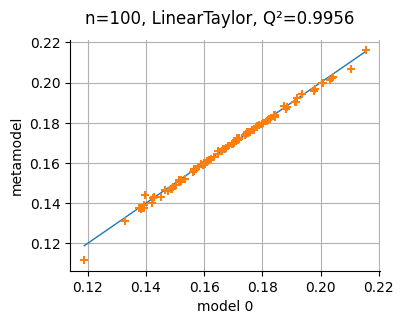

In [56]:
taylorFirstOrderExpansion = ot.LinearTaylor(inputMean, g)
graph = validateTaylorExpansion(
    inputTestSample, outputTestSample, taylorFirstOrderExpansion
)
otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

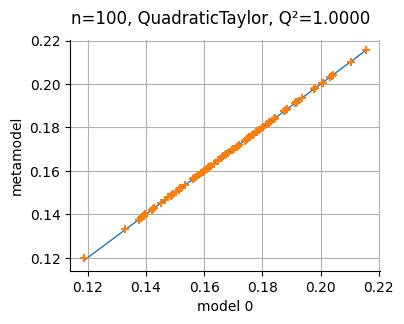

In [57]:
taylorSecondOrderExpansion = ot.QuadraticTaylor(inputMean, g)
graph = validateTaylorExpansion(
    inputTestSample, outputTestSample, taylorSecondOrderExpansion
)
otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Annexe : calcul de la valeur de référence

Dans l'exemple qui suit, nous souhaitons calculer la valeur de référence de l'espérance du modèle physique. Pour cette raison, nous utilisons une simulation Monte-Carlo fondée sur une taille d'échantillon relativement grande (avec une taille de bloc importante). Toutefois, pour pouvoir exécuter ce script dans le contexte de la machine d'intégration continue, nous configurons une taille plus petite pour le nombre maximal d'itérations externes.

In [58]:
algo = ot.ExpectationSimulationAlgorithm(Y)
# maximum_outer_sampling = 4000 # Pour de vraies simulations
maximum_outer_sampling = 100
algo.setMaximumOuterSampling(maximum_outer_sampling)
algo.setBlockSize(1000)  # ⚠️ Une taille très grande pour la référence
algo.setMaximumCoefficientOfVariation(0.0005)

algo.run()

result = algo.getResult()

outerSampleSize = result.getOuterSampling()
print(f"Nombre d'itérations = {outerSampleSize}")

expectation = result.getExpectationEstimate()
print(f"Moyenne = {expectation[0]:f}")

blocksize = result.getBlockSize()
sampleSize = outerSampleSize * blocksize
print(f"Nombre d'appels à g = {sampleSize}")

cv = result.getCoefficientOfVariation()[0]
print(f"Coef. de variation = {cv:.6f}")

sample_mean_distribution = result.getExpectationDistribution()
alpha = 0.05
sample_mean_CI = sample_mean_distribution.computeBilateralConfidenceInterval(
    1.0 - alpha
)
lower_bound = sample_mean_CI.getLowerBound()[0]
upper_bound = sample_mean_CI.getUpperBound()[0]
print(f"La probabilité que l'intervalle [{lower_bound:.4f}, {upper_bound:.4f}] ")
print(f"contienne la vraie moyenne est égale à {100.0 * (1.0 - alpha):.2f} %.")

Nombre d'itérations = 58
Moyenne = 0.170767
Nombre d'appels à g = 58000
Coef. de variation = 0.000498
La probabilité que l'intervalle [0.1706, 0.1709] 
contienne la vraie moyenne est égale à 95.00 %.


**Remarque.** En utilisant des méthodes appropriées, on peut obtenir une estimation plus précise de l'espérance du modèle de poutre encastrée (voir « Devoir-esperance-cantilever-beam-Sujet » dans [Devoir-esperance-cantilever-beam.ipynb](https://github.com/mbaudin47/otsupgalilee-eleve/blob/master/5-Chaos/Devoirs/Devoir-esperance-cantilever-beam.ipynb)).